# 0. Import

In [1]:
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

from matplotlib import rcParams#Size of plots  

import matplotlib.pylab as plt
import seaborn as sns#Plots

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

# 1. Data Load

In [2]:
location_zone_csv = pd.read_csv('/Users/jinsu/Desktop/vscode/taxi+_zone_lookup.csv')

In [3]:
# 맨해튼 지역 번호 추출
manhattan = location_zone_csv[location_zone_csv['Borough'] == 'Manhattan']
manhattan_number = manhattan['LocationID']

In [4]:
month = pd.read_parquet('/Users/jinsu/Desktop/vscode/taxi_data/yellow_tripdata_2015-01.parquet')
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2015-01-01 00:11:33,2015-01-01 00:16:48,1,1.0,1,N,41,166,1,5.7,0.5,0.5,1.40,0.0,0.0,8.40,None,None
1,1,2015-01-01 00:18:24,2015-01-01 00:24:20,1,0.9,1,N,166,238,3,6.0,0.5,0.5,0.00,0.0,0.0,7.30,None,None
2,1,2015-01-01 00:26:19,2015-01-01 00:41:06,1,3.5,1,N,238,162,1,13.2,0.5,0.5,2.90,0.0,0.0,17.40,None,None
3,1,2015-01-01 00:45:26,2015-01-01 00:53:20,1,2.1,1,N,162,263,1,8.2,0.5,0.5,2.37,0.0,0.0,11.87,None,None
4,1,2015-01-01 00:59:21,2015-01-01 01:05:24,1,1.0,1,N,236,141,3,6.0,0.5,0.5,0.00,0.0,0.0,7.30,None,None


In [5]:
month.shape

(12741035, 19)

# 2. Process and Visualization

In [6]:
manhattan_arr_data = []
for i in manhattan_number.values:
    #print(i)
    manhattan_arr_data.append(month[month['PULocationID'] == i])

In [7]:
manhattan_data = pd.concat(manhattan_arr_data, axis=0, ignore_index=True)

In [8]:
manhattan_data=manhattan_data.query("tpep_pickup_datetime >= '2015-01-01' and tpep_pickup_datetime <='2015-12-31'")
manhattan_data=manhattan_data.query("tpep_dropoff_datetime >= '2015-01-01' and tpep_dropoff_datetime <='2015-12-31'")

In [9]:
manhattan_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2015-01-01 00:05:06,2015-01-01 00:27:50,1,4.20,1,N,4,256,2,18.0,0.5,0.5,0.00,0.0,0.0,19.30,None,None
1,1,2015-01-01 00:44:28,2015-01-01 00:55:44,2,1.60,1,N,4,211,1,9.0,0.5,0.5,3.05,0.0,0.0,13.35,None,None
2,1,2015-01-01 00:40:11,2015-01-01 00:53:15,1,3.10,1,N,4,256,2,12.5,0.5,0.5,0.00,0.0,0.0,13.80,None,None
3,1,2015-01-01 00:17:30,2015-01-01 00:25:33,1,1.60,1,Y,4,144,2,8.0,0.5,0.5,0.00,0.0,0.0,9.30,None,None
4,2,2015-01-01 00:44:54,2015-01-01 00:48:39,1,1.15,1,N,4,107,1,5.5,0.5,0.5,1.20,0.0,0.3,8.00,None,None


In [10]:
manhattan_data.shape

(11613627, 19)

(11613627, 19)

In [11]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    s = np.datetime_as_string(s, unit='s')
    s = s.replace('T', ' ')

    return time.mktime(datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']]
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID','total_amount']]
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(manhattan_data)
print(frame_with_durations.head())

   passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0                1           4.20             4           256         19.30   
1                2           1.60             4           211         13.35   
2                1           3.10             4           256         13.80   
3                1           1.60             4           144          9.30   
4                1           1.15             4           107          8.00   

   trip_times  pickup_times      Speed  
0   22.733333  1.420038e+09  11.085044  
1   11.266667  1.420041e+09   8.520710  
2   13.066667  1.420040e+09  14.234694  
3    8.050000  1.420039e+09  11.925466  
4    3.750000  1.420041e+09  18.400000  


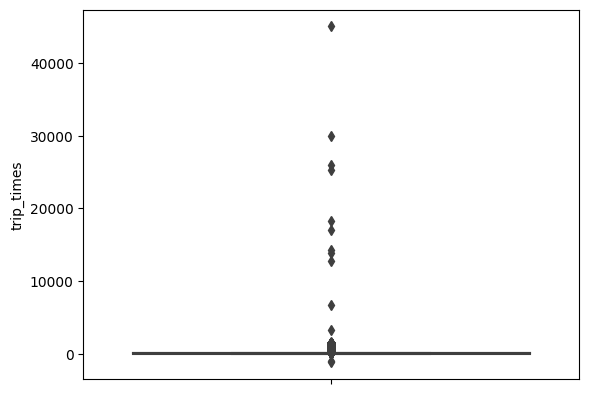

In [12]:
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [13]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.816666666666667
20 percentile value is 5.3
30 percentile value is 6.683333333333334
40 percentile value is 8.1
50 percentile value is 9.633333333333333
60 percentile value is 11.4
70 percentile value is 13.583333333333334
80 percentile value is 16.566666666666666
90 percentile value is 21.5
100 percentile value is  45108.23333333333


In [14]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 21.5
91 percentile value is 22.233333333333334
92 percentile value is 23.066666666666666
93 percentile value is 24.016666666666666
94 percentile value is 25.116666666666667
95 percentile value is 26.416666666666668
96 percentile value is 28.066666666666666
97 percentile value is 30.233333333333334
98 percentile value is 33.45
99 percentile value is 39.61666666666667
100 percentile value is  45108.23333333333


In [15]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

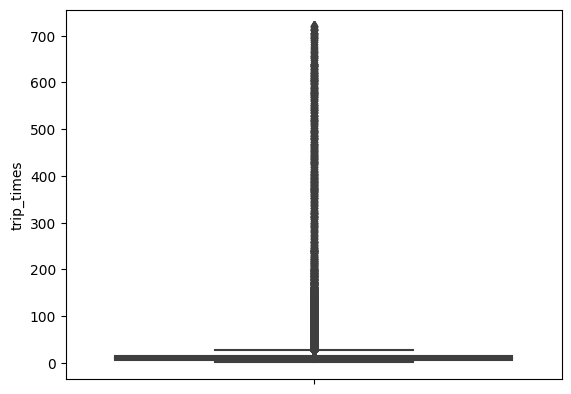

In [16]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

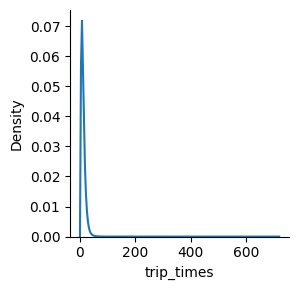

In [17]:
#pdf of trip-times after removing the outliers #size=6인거 지웠는데 무엇을 의미..?
sns.FacetGrid(frame_with_durations_modified) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend()
plt.show()

In [18]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

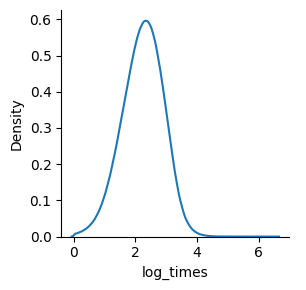

In [19]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified) \
      .map(sns.kdeplot,"log_times") \
      .add_legend()
plt.show()

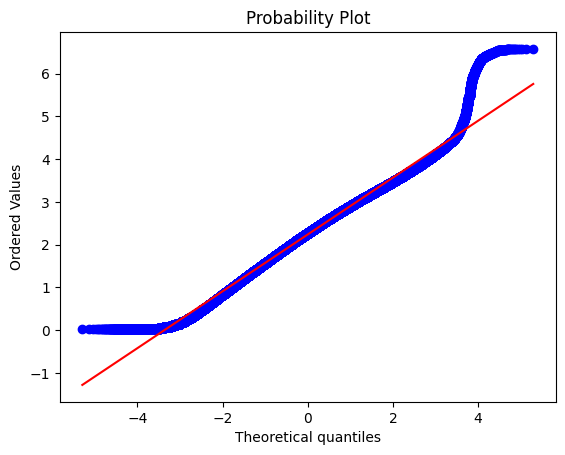

In [20]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

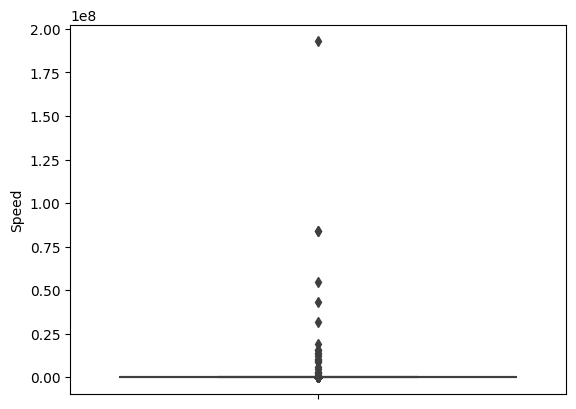

In [21]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [22]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.315789473684211
20 percentile value is 7.674418604651163
30 percentile value is 8.753799392097266
40 percentile value is 9.757489300998573
50 percentile value is 10.781249999999998
60 percentile value is 11.909262759924387
70 percentile value is 13.26962457337884
80 percentile value is 15.131348511383534
90 percentile value is 18.43289371605896
100 percentile value is  192857142.85714284


In [23]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 18.43289371605896
91 percentile value is 18.967071057192374
92 percentile value is 19.586206896551726
93 percentile value is 20.303687635574835
94 percentile value is 21.16901408450704
95 percentile value is 22.199108469539375
96 percentile value is 23.501222493887532
97 percentile value is 25.203761755485896
98 percentile value is 27.58681318681319
99 percentile value is 31.50282485875706
100 percentile value is  192857142.85714284


In [24]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 31.50282485875706
99.1 percentile value is 32.071269487750556
99.2 percentile value is 32.70229007633588
99.3 percentile value is 33.404752315747075
99.4 percentile value is 34.20647149460709
99.5 percentile value is 35.11156812339332
99.6 percentile value is 36.17142857142857
99.7 percentile value is 37.5
99.8 percentile value is 39.27272727272727
99.9 percentile value is 42.03754693366708
100 percentile value is  192857142.85714284


In [25]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [26]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

11.826809215512123

# trip distance

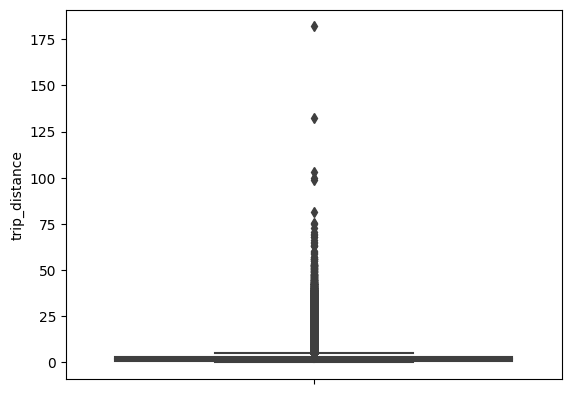

In [27]:
sns.boxplot(y="trip_distance", data=frame_with_durations_modified)
plt.show()

In [28]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.01
10 percentile value is 0.64
20 percentile value is 0.88
30 percentile value is 1.1
40 percentile value is 1.3
50 percentile value is 1.6
60 percentile value is 1.93
70 percentile value is 2.4
80 percentile value is 3.18
90 percentile value is 4.78
100 percentile value is 181.96


In [29]:
for i in range(90, 100):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

90 percentile value is 4.78
91 percentile value is 5.04
92 percentile value is 5.37
93 percentile value is 5.72
94 percentile value is 6.2
95 percentile value is 6.78
96 percentile value is 7.6
97 percentile value is 8.78
98 percentile value is 10.3
99 percentile value is 14.0
100 percentile value is 181.96


In [30]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 14.0
99.1 percentile value is 15.0
99.2 percentile value is 15.98
99.3 percentile value is 16.52
99.4 percentile value is 16.91
99.5 percentile value is 17.3
99.6 percentile value is 17.7
99.7 percentile value is 18.21
99.8 percentile value is 19.11
99.9 percentile value is 20.5
100 percentile value is  181.96


In [31]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

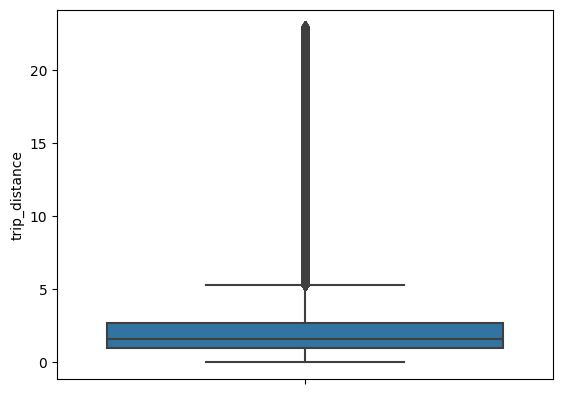

In [32]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

# total fare

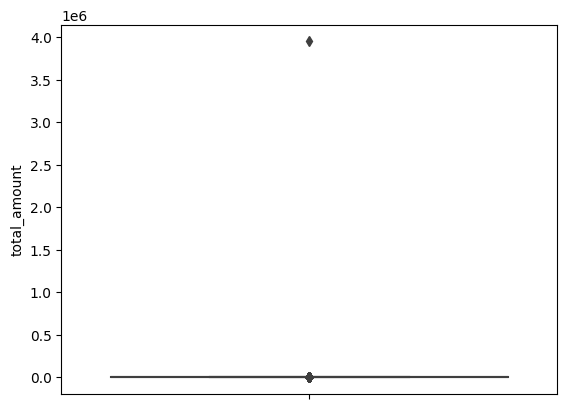

In [33]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [34]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.55
30 percentile value is 8.6
40 percentile value is 9.8
50 percentile value is 10.8
60 percentile value is 12.3
70 percentile value is 14.15
80 percentile value is 16.8
90 percentile value is 22.25
100 percentile value is  3950611.6


In [35]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 22.25
91 percentile value is 23.0
92 percentile value is 24.1
93 percentile value is 25.3
94 percentile value is 26.75
95 percentile value is 28.55
96 percentile value is 31.0
97 percentile value is 35.13
98 percentile value is 41.13
99 percentile value is 53.8
100 percentile value is  3950611.6


In [36]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 53.8
99.1 percentile value is 57.8
99.2 percentile value is 58.13
99.3 percentile value is 59.8
99.4 percentile value is 63.2
99.5 percentile value is 66.0
99.6 percentile value is 69.6
99.7 percentile value is 69.75
99.8 percentile value is 72.66
99.9 percentile value is 85.25
100 percentile value is  3950611.6


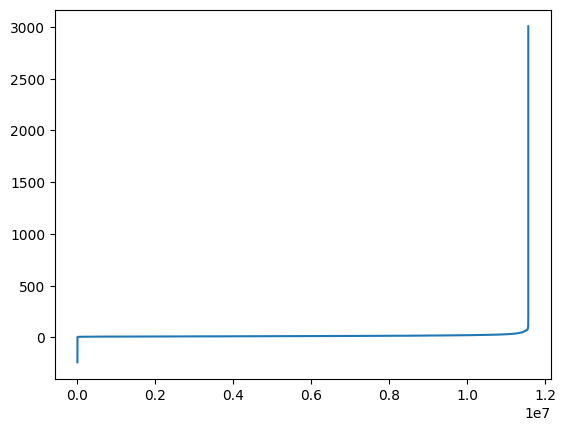

In [37]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

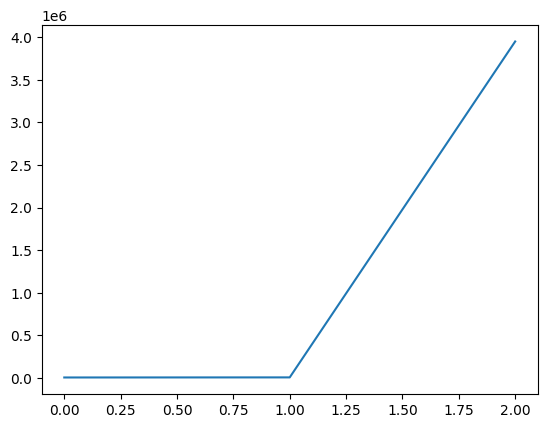

In [38]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

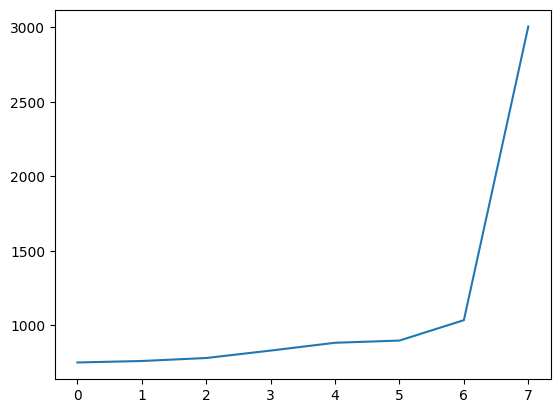

In [39]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-10:-2])
plt.show()

In [40]:
# 1. 이상한 시간
# 2. 이상한 속도
# 3. 이상한 거리
# 4. 이상한 비용
# 5. 이상한 팁
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    print("총 데이터 수 = ", a)

    # 시간
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("시간 튀는 값의 개수:",(a-c))
    
    # 거리
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("거리 튀는 값의 개수:",(a-d))

    # 속도
    temp_frame = new_frame[(new_frame.Speed < 65) & (new_frame.Speed > 0)]
    e = temp_frame.shape[0]
    print ("속도 튀는 값의 개수",(a-e))

    # 비용
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("비용 튀는 값의 개수:",(a-f))

    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 65) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]

    print("전체 삭제 된 데이터 수", a-new_frame.shape[0])
    print("---")
    return new_frame

In [41]:
print("2015-01 데이터 제거 현황")
print("---")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("튀는 값 제거하고 남은 비율", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

2015-01 데이터 제거 현황
---
총 데이터 수 =  11613627
시간 튀는 값의 개수: 19384
거리 튀는 값의 개수: 45554
속도 튀는 값의 개수 46982
비용 튀는 값의 개수: 3196
전체 삭제 된 데이터 수 61180
---
튀는 값 제거하고 남은 비율 0.9947320505471718


In [42]:
for location_id, index in zip(manhattan_number, range(1, len(manhattan_number)+1)):
    frame_with_durations_outliers_removed.loc[frame_with_durations_outliers_removed['PULocationID'] == location_id, 'PULocationID'] = index
frame_with_durations_outliers_removed

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_times,pickup_times,Speed
0,1,4.20,1,256,19.30,22.733333,1.420038e+09,11.085044
1,2,1.60,1,211,13.35,11.266667,1.420041e+09,8.520710
2,1,3.10,1,256,13.80,13.066667,1.420040e+09,14.234694
3,1,1.60,1,144,9.30,8.050000,1.420039e+09,11.925466
4,1,1.15,1,107,8.00,3.750000,1.420041e+09,18.400000
...,...,...,...,...,...,...,...,...
11613622,1,4.10,69,79,17.80,22.200000,1.422716e+09,11.081081
11613623,1,4.20,69,148,24.35,25.733333,1.422715e+09,9.792746
11613624,2,2.80,69,230,18.35,19.066667,1.422713e+09,8.811189
11613625,6,0.39,69,75,4.80,2.100000,1.422715e+09,11.142857


# 3. Gruoping

In [43]:
#Refer:https://www.unixtimestamp.com/
# 1577804400 : 2015-01-01 00:00:00 
# 1580482800 : 2015-02-01 00:00:00 
# 1582988400 : 2015-03-01 00:00:00
# 1585666800 : 2015-04-01 00:00:00 
# 1588258800 : 2015-05-01 00:00:00 
# 1590937200 : 2015-06-01 00:00:00

# 1609426800 : 2016-01-01 00:00:00 
# 1612105200 : 2016-02-01 00:00:00 
# 1614524400 : 2016-03-01 00:00:00
# 1617202800 : 2016-04-01 00:00:00 
# 1619794800 : 2016-05-01 00:00:00 
# 1622473200 : 2016-06-01 00:00:00
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420038000,1422716400,1425135600,1427814000,1430406000,1433084400],\
                    [1451574000,1454252400,1456758000,1459436400,1462028400,1464706800]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]

    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [44]:
jan_previous_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)

In [45]:
jan_previous_groupy = jan_previous_frame[['PULocationID', 'pickup_bins', 'trip_distance']].groupby(['PULocationID', 'pickup_bins']).count()

In [46]:
jan_previous_frame.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_times,pickup_times,Speed,pickup_bins
0,1,4.20,1,256,19.30,22.733333,1.420038e+09,11.085044,33
1,2,1.60,1,211,13.35,11.266667,1.420041e+09,8.520710,37
2,1,3.10,1,256,13.80,13.066667,1.420040e+09,14.234694,37
3,1,1.60,1,144,9.30,8.050000,1.420039e+09,11.925466,34
4,1,1.15,1,107,8.00,3.750000,1.420041e+09,18.400000,37


In [47]:
jan_previous_groupy.head()

trip_distance
PULocationID pickup_bins               
1            33                      14
             34                      24
             35                      32
             36                      30
             37                      45

In [48]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['PULocationID', 'pickup_bins', 'trip_distance']].groupby(['PULocationID', 'pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
year = '2016'
month_jan = pd.read_parquet('/Users/jinsu/Desktop/vscode/taxi_data/yellow_tripdata_{0}-01.parquet'.format(year))
month_feb = pd.read_parquet('/Users/jinsu/Desktop/vscode/taxi_data/yellow_tripdata_{0}-02.parquet'.format(year))
month_mar = pd.read_parquet('/Users/jinsu/Desktop/vscode/taxi_data/yellow_tripdata_{0}-03.parquet'.format(year))
month_apr = pd.read_parquet('/Users/jinsu/Desktop/vscode/taxi_data/yellow_tripdata_{0}-04.parquet'.format(year))
month_may = pd.read_parquet('/Users/jinsu/Desktop/vscode/taxi_data/yellow_tripdata_{0}-05.parquet'.format(year))
month_jun = pd.read_parquet('/Users/jinsu/Desktop/vscode/taxi_data/yellow_tripdata_{0}-06.parquet'.format(year))

jan_frame, jan_groupby = datapreparation(month_jan, 1, int(year))
feb_frame, feb_groupby = datapreparation(month_feb, 2, int(year))
mar_frame, mar_groupby = datapreparation(month_mar, 3, int(year))
apr_frame, apr_groupby = datapreparation(month_apr, 4, int(year))
may_frame, may_groupby = datapreparation(month_may, 5, int(year))
jun_frame, jun_groupby = datapreparation(month_jun, 6, int(year))

Return with trip times..
Remove outliers..
총 데이터 수 =  10905067
시간 튀는 값의 개수: 27122
거리 튀는 값의 개수: 78488
속도 튀는 값의 개수 72765
비용 튀는 값의 개수: 4664
전체 삭제 된 데이터 수 107073
---
Final groupbying..
Return with trip times..
Remove outliers..
총 데이터 수 =  11375412
시간 튀는 값의 개수: 27554
거리 튀는 값의 개수: 77091
속도 튀는 값의 개수 73145
비용 튀는 값의 개수: 4821
전체 삭제 된 데이터 수 105738
---
Final groupbying..
Return with trip times..
Remove outliers..
총 데이터 수 =  12203824
시간 튀는 값의 개수: 30729
거리 튀는 값의 개수: 82262
속도 튀는 값의 개수 77690
비용 튀는 값의 개수: 5059
전체 삭제 된 데이터 수 115374
---
Final groupbying..
Return with trip times..
Remove outliers..
총 데이터 수 =  11927996
시간 튀는 값의 개수: 37794
거리 튀는 값의 개수: 88891
속도 튀는 값의 개수 84303
비용 튀는 값의 개수: 5122
전체 삭제 된 데이터 수 121370
---
Final groupbying..
Return with trip times..
Remove outliers..
총 데이터 수 =  11832049
시간 튀는 값의 개수: 29521
거리 튀는 값의 개수: 87251
속도 튀는 값의 개수 79978
비용 튀는 값의 개수: 5465
전체 삭제 된 데이터 수 119982
---
Final groupbying..
Return with trip times..
Remove outliers..
총 데이터 수 =  11131645
시간 튀는 값의 개수: 27535
거리 튀는 값의 개수: 

In [49]:
jan_previous_frame

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_times,pickup_times,Speed,pickup_bins
0,1,4.20,1,256,19.30,22.733333,1.420038e+09,11.085044,33
1,2,1.60,1,211,13.35,11.266667,1.420041e+09,8.520710,37
2,1,3.10,1,256,13.80,13.066667,1.420040e+09,14.234694,37
3,1,1.60,1,144,9.30,8.050000,1.420039e+09,11.925466,34
4,1,1.15,1,107,8.00,3.750000,1.420041e+09,18.400000,37
...,...,...,...,...,...,...,...,...,...
11613622,1,4.10,69,79,17.80,22.200000,1.422716e+09,11.081081,4495
11613623,1,4.20,69,148,24.35,25.733333,1.422715e+09,9.792746,4494
11613624,2,2.80,69,230,18.35,19.066667,1.422713e+09,8.811189,4492
11613625,6,0.39,69,75,4.80,2.100000,1.422715e+09,11.142857,4494


# SMOOTHING

In [50]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# [적어도 1번 픽업이 발생한 지역의 모든 인덱스를 얻는다]
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(1,70):
        new = frame[frame['PULocationID'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [51]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_previous_unique = return_unq_pickup_bins(jan_previous_frame)
jan_unique = return_unq_pickup_bins(jan_frame)

#feb
feb_unique = return_unq_pickup_bins(feb_frame)

#march
mar_unique = return_unq_pickup_bins(mar_frame)

#april
apr_unique = return_unq_pickup_bins(apr_frame)

#may
may_unique = return_unq_pickup_bins(may_frame)

#june
jun_unique = return_unq_pickup_bins(jun_frame)

In [52]:
# 31일 * 24시간 * 60분 / 60분 = month_interval_31 -> 10분
month_interval_31 = int(31 * 24 * 60 / 10)
month_interval_30 = int(30 * 24 * 60 / 10)
month_interval_29 = int(29 * 24 * 60 / 10)
month_interval_28 = int(28 * 24 * 60 / 10)

In [53]:
# 31일 * 24시간 * 60분 / 10분 = month_interval_31
# 최대가 month_interval_31겠지
for i in range(1, 70):
    print(i, "번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수", month_interval_31-len(set(jan_previous_unique[i-1])))
    print("-"* 60)

1 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 109
------------------------------------------------------------
2 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 2679
------------------------------------------------------------
3 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 213
------------------------------------------------------------
4 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 170
------------------------------------------------------------
5 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 114
------------------------------------------------------------
6 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 404
------------------------------------------------------------
7 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 159
------------------------------------------------------------
8 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 360
------------------------------------------------------------
9 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 32
------------------------------------------------------------
10 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 59
-----------------------------------------

In [190]:
# 탑승 기록이 없으면 0으로 채우기
# count_values: 각 지역 각 10분 간격에 픽업 수
# values: 픽업 기록이 있는 간격의 set
def fill_missing(count_values, values):
    smoothed_regions = []
    ind = 0
    for r in range(1, 70): # 각 구역마다
        smoothed_bins = []
        for i in range(month_interval_31):
            if i in values[r-1]: # interval 안에 탑승 기록이 있으면
                smoothed_bins.append(count_values[ind])
                ind += 1
            else: # interval 안에 탑승 기록이 없으면
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [68]:
# 빈값을 평균으로 채우기
# interval 안에 pickup 기록이 없다면
# pickup 기록이 있는 자신과 가장 가까운 양 끝값을 이용하여 평균을 구함
def smoothing(count_values,values):
    smoothed_regions=[] # 각 지역마다 최종 smoothed 값을 저장할 리스트
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(1,70): # 지역마다
        smoothed_bins=[] # 최종 smoothed 값을 저장할 리스트
        repeat=0
        for i in range(month_interval_31): # interval 마다
            if repeat!=0: # 같은 interval을 여러 번 계산 방지
                repeat-=1
                continue
            if i in values[r-1]: # interval 안에 픽업 기록이 존재하면
                smoothed_bins.append(count_values[ind]) # interval을 리스트에 추가
            else:
                if i!=0: # 첫 구간이 아니면 (left~rigth or right~끝)
                    right_hand_limit=0
                    for j in range(i,month_interval_31):
                        if  j not in values[r-1]: # interval안에 픽업이 없는 경우 평균값으로 채워져야 하므로 넘어감
                            continue
                        else:
                            right_hand_limit=j # interval안에 픽업이 존재하는 경우에 right_limit이 됨
                            break
                    if right_hand_limit==0:
                    #Case 1: right~끝
                        smoothed_value=count_values[ind-1]*1.0/(((month_interval_31-1)-i)+2)*1.0                               
                        for j in range(i,month_interval_31): # right~끝까지 평균으로 채우기              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=((month_interval_31-1)-i)
                        ind-=1
                    else:
                    #Case 2: left~right
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1): # left~right까지 평균으로 채우기   
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: 처음~right
                    right_hand_limit=0
                    for j in range(i,month_interval_31):
                        if  j not in values[r-1]:
                            continue
                        else:
                            right_hand_limit=j # interval 안에 픽업이 존재하는 경우 right가 됨
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):# 처음~left까지 평균으로 채우기
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [191]:
jan_previous_fill = fill_missing(jan_previous_groupy['trip_distance'].values , jan_previous_unique)

In [192]:
jan_previous_smooth = smoothing(jan_previous_groupy['trip_distance'].values, jan_previous_unique)

In [139]:
print("number of 10min intravels among all the clusters ",len(jan_previous_fill))

number of 10min intravels among all the clusters  308016


In [140]:
all_loc_interval = len(jan_previous_fill)
print("모든 클러스터 사이에 1시간 interval 수", all_loc_interval)

모든 클러스터 사이에 1시간 interval 수 308016


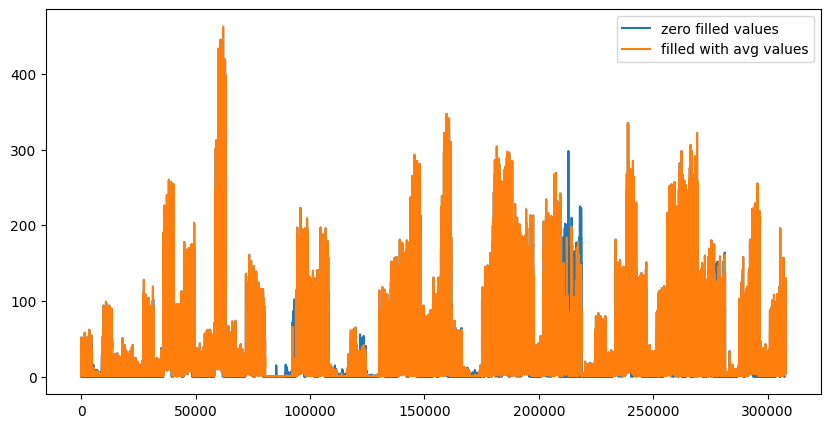

In [73]:
# 2015-01 10분 interval 탑승 빈도
plt.figure(figsize=(10, 5))
plt.plot(jan_previous_fill[0:all_loc_interval], label = "zero filled values")
plt.plot(jan_previous_smooth[0:all_loc_interval], label="filled with avg values")
plt.legend()
plt.show()

In [193]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_previous_smooth = smoothing(jan_previous_groupy['trip_distance'].values,jan_previous_unique)
jan_smooth = fill_missing(jan_groupby['trip_distance'].values, jan_unique)
feb_smooth = fill_missing(feb_groupby['trip_distance'].values, feb_unique)
mar_smooth = fill_missing(mar_groupby['trip_distance'].values, mar_unique)
apr_smooth = fill_missing(apr_groupby['trip_distance'].values, apr_unique)
may_smooth = fill_missing(may_groupby['trip_distance'].values, may_unique)
jun_smooth = fill_missing(jun_groupby['trip_distance'].values, jun_unique)


# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015 = 24*31*60/10 = month_interval_31
# number of 10min indices for jan 2016 = 24*31*60/10 = month_interval_31
# number of 10min indices for feb 2016 = 24*29*60/10 = month_interval_29
# number of 10min indices for march 2016 = 24*31*60/10 = month_interval_31
# regions_cum: it will contain 265 lists, each list will contain month_interval_31+month_interval_29+month_interval_31 values which represents the number of pickups 
# that are happened for three months in 2016 data

# i -> i-1, i+1 -> i
for i in range(1,70):
    regions_cum.append(jan_smooth[month_interval_31*(i-1):month_interval_31*i]+ \
        feb_smooth[month_interval_29*(i-1):month_interval_29*i]+ \
            mar_smooth[month_interval_31*(i-1):month_interval_31*i]+ \
                apr_smooth[month_interval_30*(i-1):month_interval_30*i]+ \
                    may_smooth[month_interval_31*(i-1):month_interval_31*i]+ \
                        jun_smooth[month_interval_30*(i-1):month_interval_30*i])


In [189]:
print(len(regions_cum))
print(len(regions_cum[0]))

69
26208


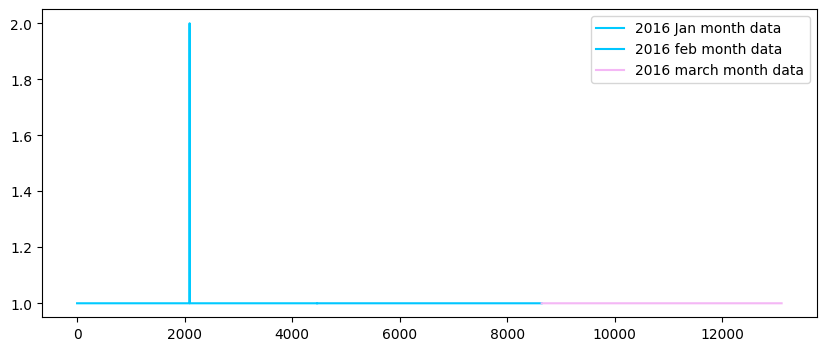

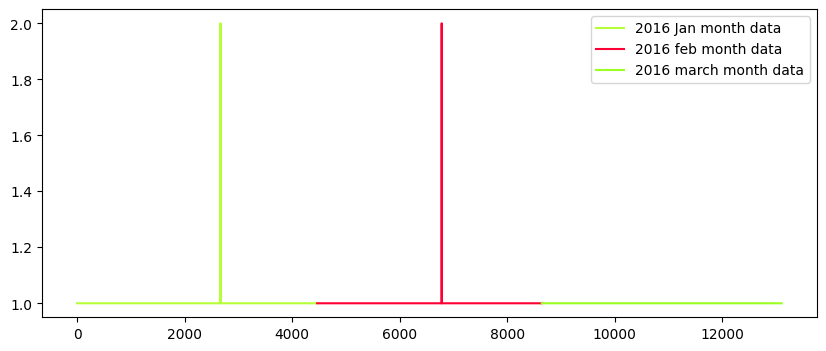

In [126]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,month_interval_31))
second_x = list(range(month_interval_31,month_interval_31 + month_interval_29))
third_x = list(range(month_interval_31 + month_interval_29,month_interval_31 + month_interval_29 + month_interval_31))
for i in range(1, 3):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i-1][:month_interval_31], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i-1][month_interval_31:month_interval_31 + month_interval_29], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,regions_cum[i-1][month_interval_31 + month_interval_29:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

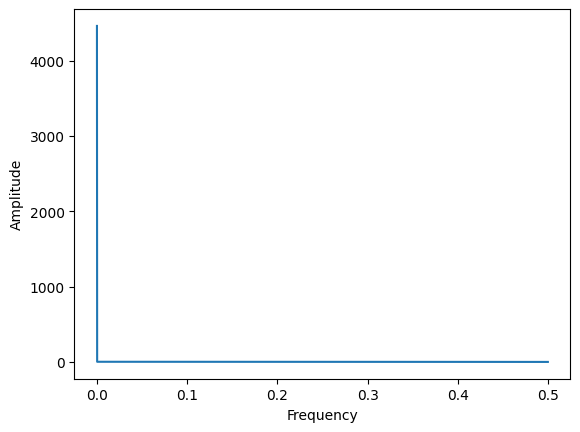

In [127]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(month_interval_31, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [194]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_previous_smooth
ratios_jan['Prediction']=jan_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [129]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,month_interval_31*69):
        if i%month_interval_31==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [130]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,month_interval_31*69):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [131]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,month_interval_31*69):
        if i%month_interval_31==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [132]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,month_interval_31*69):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [133]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,month_interval_31*69):
        if i%month_interval_31==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [134]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,month_interval_31*69):
        if i%month_interval_31==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [195]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

In [196]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.5053884637093805       MSE:  129.2852449223417
Moving Averages (2016 Values) -                        MAPE:  0.3589989447445826        MSE:  34.449087060412445
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.5045137586374935       MSE:  127.64773907848942
Weighted Moving Averages (2016 Values) -               MAPE:  0.33161839720374847       MSE:  27.26947301438886
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.5026469031233457       MSE:  119.75131162017557
Exponential Moving Averages (2016 Values) -         MAPE:  0.330549118458

In [198]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = month_interval_31
# number of 10min indices for jan 2016 = 24*31*60/10 = month_interval_31
# number of 10min indices for feb 2016 = 24*28*60/10 = month_interval_29
# number of 10min indices for march 2016 = 24*31*60/10 = month_interval_31
# regions_cum: it will contain 265 lists, each list will contain month_interval_31+month_interval_29+month_interval_31 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 265
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups month_interval_31 + month_interval_29 + month_interval_31 for each cluster
output = []

tsne_destination = []
# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding month_interval_31 + month_interval_29 + month_interval_31 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []

tsne_feature = [0]*number_of_time_stamps

for i in range(1,70):
    tsne_destination.append([i]*(month_interval_31*3 + month_interval_29 + month_interval_30*2 - 5))
    # jan 1st 2016 is 금요일, so we start our day from 5: "(int(k/144))%7+5"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+5)%7) for k in range(5, month_interval_31*3+month_interval_29+month_interval_30*2)])
    # regions_cum is a list of lists [[x1,x2,x3..xmonth_interval_31 + month_interval_29 + month_interval_31], [x1,x2,x3..xmonth_interval_31 + month_interval_29 + month_interval_31], [x1,x2,x3..xmonth_interval_31 + month_interval_29 + month_interval_31], [x1,x2,x3..xmonth_interval_31 + month_interval_29 + month_interval_31], [x1,x2,x3..xmonth_interval_31 + month_interval_29 + month_interval_31], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i-1][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i-1])-number_of_time_stamps)]))
    
    output.append(regions_cum[i-1][5:])
tsne_feature = tsne_feature[1:]

In [199]:

print(len(tsne_destination)*len(tsne_destination[0]))
print(tsne_feature.shape[0])
print(len(tsne_weekday)*len(tsne_weekday[0]))
print(69*(month_interval_31*3 + month_interval_29 + 2*month_interval_30 - 5))
print(len(output)*len(output[0]))

1808007
1808007
1808007
1808007
1808007


In [200]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains month_interval_31 + month_interval_29 + month_interval_31 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..xmonth_interval_31 + month_interval_29 + month_interval_31], [x5,x6,x7..xmonth_interval_31 + month_interval_29 + month_interval_31], [x5,x6,x7..xmonth_interval_31 + month_interval_29 + month_interval_31], [x5,x6,x7..xmonth_interval_31 + month_interval_29 + month_interval_31], [x5,x6,x7..xmonth_interval_31 + month_interval_29 + month_interval_31], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(1,70):
    for i in range(0,month_interval_31*3 + month_interval_29 + month_interval_30*2):
        if i==0:
            predicted_value= regions_cum[r-1][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r-1][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [201]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
train_size = int((month_interval_31*3 + month_interval_29 + month_interval_30*2 - 5)*0.7)
test_size = int((month_interval_31*3 + month_interval_29 + month_interval_30*2 - 5)*0.3)
print("size of train data :", int((month_interval_31*3 + month_interval_29 + month_interval_30*2 - 5)*0.7))
print("size of test data :", int((month_interval_31*3 + month_interval_29 + month_interval_30*2 - 5)*0.3))

size of train data : 18342
size of test data : 7860


In [202]:
# extracting first train_size timestamp values i.e 70% of month_interval_31 + month_interval_29 + month_interval_31 (total timestamps) for our training data
train_features =  [tsne_feature[(i-1)*(month_interval_31*3 + month_interval_29 + month_interval_30*2 -5):((month_interval_31*3 + month_interval_29 + month_interval_30*2-5)*(i-1)+train_size)] for i in range(1,70)]
# temp = [0]*(month_interval_31 + month_interval_29 + month_interval_31 - train_size)
test_features = [tsne_feature[((month_interval_31*3 + month_interval_29 + month_interval_30*2-5)*(i-1))+train_size:(month_interval_31*3 + month_interval_29 + month_interval_30*2-5)*i] for i in range(1,70)]

In [150]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 69 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 69 Number of data points in test data 3930 Each data point contains 5 features


In [203]:
# extracting first 9169 timestamp values i.e 70% of month_interval_31 + month_interval_29 + month_interval_31 (total timestamps) for our training data
tsne_train_flat_destination = [i[:train_size] for i in tsne_destination]
tsne_train_flat_weekday = [i[:train_size] for i in tsne_weekday]
tsne_train_flat_output = [i[:train_size] for i in output]
tsne_train_flat_exp_avg = [i[:train_size] for i in predict_list]

In [204]:
# extracting the rest of the timestamp values i.e 30% of month_interval_31 + month_interval_29 + month_interval_31 (total timestamps) for our test data
tsne_test_flat_destination = [i[train_size:] for i in tsne_destination]
tsne_test_flat_weekday = [i[train_size:] for i in tsne_weekday]
tsne_test_flat_output = [i[train_size:] for i in output]
tsne_test_flat_exp_avg = [i[train_size:] for i in predict_list]

In [205]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(1,70):
    train_new_features.extend(train_features[i-1])
test_new_features = []
for i in range(1,70):
    test_new_features.extend(test_features[i-1])

In [206]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]
tsne_train_destination = sum(tsne_train_flat_destination, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [207]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]
tsne_test_destination = sum(tsne_test_flat_destination, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [208]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns)
df_train['destination'] = tsne_train_destination
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(1265598, 8)


In [209]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns)
df_test['destination'] = tsne_test_destination
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(542409, 8)


In [210]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,destination,weekday,exp_avg
0,0,0,0,0,0,1,6,0
1,0,0,0,0,0,1,6,0
2,0,0,0,0,0,1,6,0
3,0,0,0,0,0,1,6,0
4,0,0,0,0,0,1,6,0


In [211]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

In [212]:
# Training a hyper-parameter tuned random forest regressor on our train data
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [213]:
# Predicting on test data using our trained random forest model 

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [214]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'destination', 'weekday',
       'exp_avg'],
      dtype='object')
[0.09787356 0.14585049 0.14617784 0.24174326 0.1439094  0.00803506
 0.00291069 0.2134997 ]


# Using XGBoost

In [215]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBRegressor function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# -------------------------
# default paramters
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
# missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=200, ...)

In [216]:
#predicting with our trained Xg-Boost regressor
# the models x_model is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [217]:
#feature importances
x_model.get_booster().get_score(importance_type='weight')

{'ft_5': 1008.0,
 'ft_4': 1060.0,
 'ft_3': 1042.0,
 'ft_2': 815.0,
 'ft_1': 1053.0,
 'destination': 709.0,
 'weekday': 365.0,
 'exp_avg': 814.0}

In [222]:
print("linear regression: ", lr_reg.score(df_test, tsne_test_output))
print("Random Forest Regression: ", regr1.score(df_test, tsne_test_output))
print("XgBoost Regression: ", x_model.score(df_test, tsne_test_output))

linear regression:  0.9407052672388676
Random Forest Regression:  0.945043803156505
XgBoost Regression:  0.9457500897274425


In [219]:
train_mae=[]
test_mae=[]
train_mae.append(mean_absolute_error(tsne_train_output,df_train['ft_1'].values))
train_mae.append(mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))
train_mae.append((mean_absolute_error(tsne_train_output,rndf_train_predictions)))
train_mae.append((mean_absolute_error(tsne_train_output, xgb_train_predictions)))
train_mae.append((mean_absolute_error(tsne_train_output, lr_train_predictions)))

test_mae.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values)))
test_mae.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values)))
test_mae.append((mean_absolute_error(tsne_test_output, rndf_test_predictions)))
test_mae.append((mean_absolute_error(tsne_test_output, xgb_test_predictions)))
test_mae.append((mean_absolute_error(tsne_test_output, lr_test_predictions)))

In [220]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mae[0],"      Test: ",test_mae[0])
print ("Exponential Averages Forecasting -           Train: ",train_mae[1],"      Test: ",test_mae[1])
print ("Linear Regression -                         Train: ",train_mae[4],"      Test: ",test_mae[4])
print ("Random Forest Regression -                   Train: ",train_mae[2],"     Test: ",test_mae[2])
print ("XgBoost Regression -                         Train: ",train_mae[3],"      Test: ",test_mae[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  1.1585274313012506       Test:  1.1212627371595973
Exponential Averages Forecasting -           Train:  1.061389161487297       Test:  1.0220682178946146
Linear Regression -                         Train:  1.0506606363157969       Test:  1.0098320639959883
Random Forest Regression -                   Train:  0.8453616393199105      Test:  1.0122416847803042
XgBoost Regression -                         Train:  1.029528333641488       Test:  0.9951918201947239
--------------------------------------------------------------------------------------------------------
